### Testing area for the summary plots for EMEWS instances with pcdl

This will use a specific instance folder, and then showcase the different plots we can make, as well as the general, summary plot

In [1]:
import re, os, sys, warnings
import numpy as np
import scipy as sp
from scipy import interpolate, integrate
import pandas as pd
import xml.dom.minidom
import matplotlib.pyplot as plt
import seaborn as sns
import pcdl
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append("./python") # for running locally 
# from multicellds import MultiCellDS
import pickle

In [3]:
output_folder = "../../experiments/testing_area/instance_3240_8/output"
instance_folder = "../../experiments/v2_test_sweep/instance_3240_8"
experimental_data_path = "../../data/AGS_data/AGS_growth_data/output/csv/"
color_dict = {"alive": "g", "apoptotic": "r",  "necrotic":"k"}
color_number_dict = {"14": "g", "100": "r",  "101":"k"}
drug_name = "PI3K"

In [ ]:
def save_pcdl_timeseries(output_folder, instance_folder):
    " Saves a pickle with the TimeSeries object from pcdl, as well as some tabular data "
    mcdsts = pcdl.TimeSeries(output_path = output_folder, graph=True)
    pickle_path = os.path.join(instance_folder, "pcdl_timeseries.pkl")
    with open(pickle_path, 'wb') as a:
        pickle.dump(mcdsts, a)

    # also save ALL data in tabular format
    list_of_relevant_vars = list()
    all_data = pd.DataFrame()
    for mcds in mcdsts.get_mcds_list():
        frame_df = mcds.get_cell_df()
        frame_df.reset_index(inplace=True)
        list_of_relevant_vars.append(frame_df)

    all_data = pd.concat(list_of_relevant_vars, ignore_index=True) 
    all_data.to_csv(os.path.join(instance_folder, "pcdl_total_info_sim.csv"), header=True, index=False)

    # only keep alive cells
    # @oth: #TODO complete this dictionary or find it somewhere 
    state_to_code = {
        'live': 5,
        'apoptotic': 100,
        'necrotic': 101
    }

    all_data_tmp = all_data.copy()
    all_data_tmp['current_phase_number'] = all_data_tmp['current_phase'].map(state_to_code)
    all_data_alive = all_data_tmp[all_data_tmp['current_phase_number'] <= 14]
    # Aggregate based on time and filter only by alive cells (current_phase <=14)
    time_aggregated_data_all = all_data.groupby('time').mean(numeric_only=True)
    time_aggregated_data_alive = all_data_alive.groupby('time').mean(numeric_only=True)

    # If we want to set the time as index
    # time_aggregated_data_all.reset_index(inplace=True)
    # time_aggregated_data_all.set_index('time', inplace=True)

    # alive_df = time_aggregated_data_all[["time", "alive"]]
    # alive_df.to_csv( os.path.join(instance_folder, 'simulation_growth.csv'), header=True, index=False)
    time_aggregated_data_alive.to_csv( os.path.join(instance_folder, 'pcdl_celldata_alive_agg.csv'), header=True, index=False)
    time_aggregated_data_all.to_csv( os.path.join(instance_folder, 'pcdl_celldata_all_agg.csv'), header=True, index=False)

    return all_data, time_aggregated_data_all, time_aggregated_data_alive

df_time_course, df_cell_variables_total, df_cell_variables = save_pcdl_timeseries(output_folder, instance_folder)

In [4]:
df_time_course = pd.read_csv(os.path.join(instance_folder, "pcdl_total_info_sim.csv"))
df_cell_variables = pd.read_csv(os.path.join(instance_folder, "pcdl_celldata_alive_agg.csv"))
df_cell_variables_total = pd.read_csv(os.path.join(instance_folder, "pcdl_celldata_all_agg.csv"))

### plotting cells

Alive/Apoptotic cells plot obtained


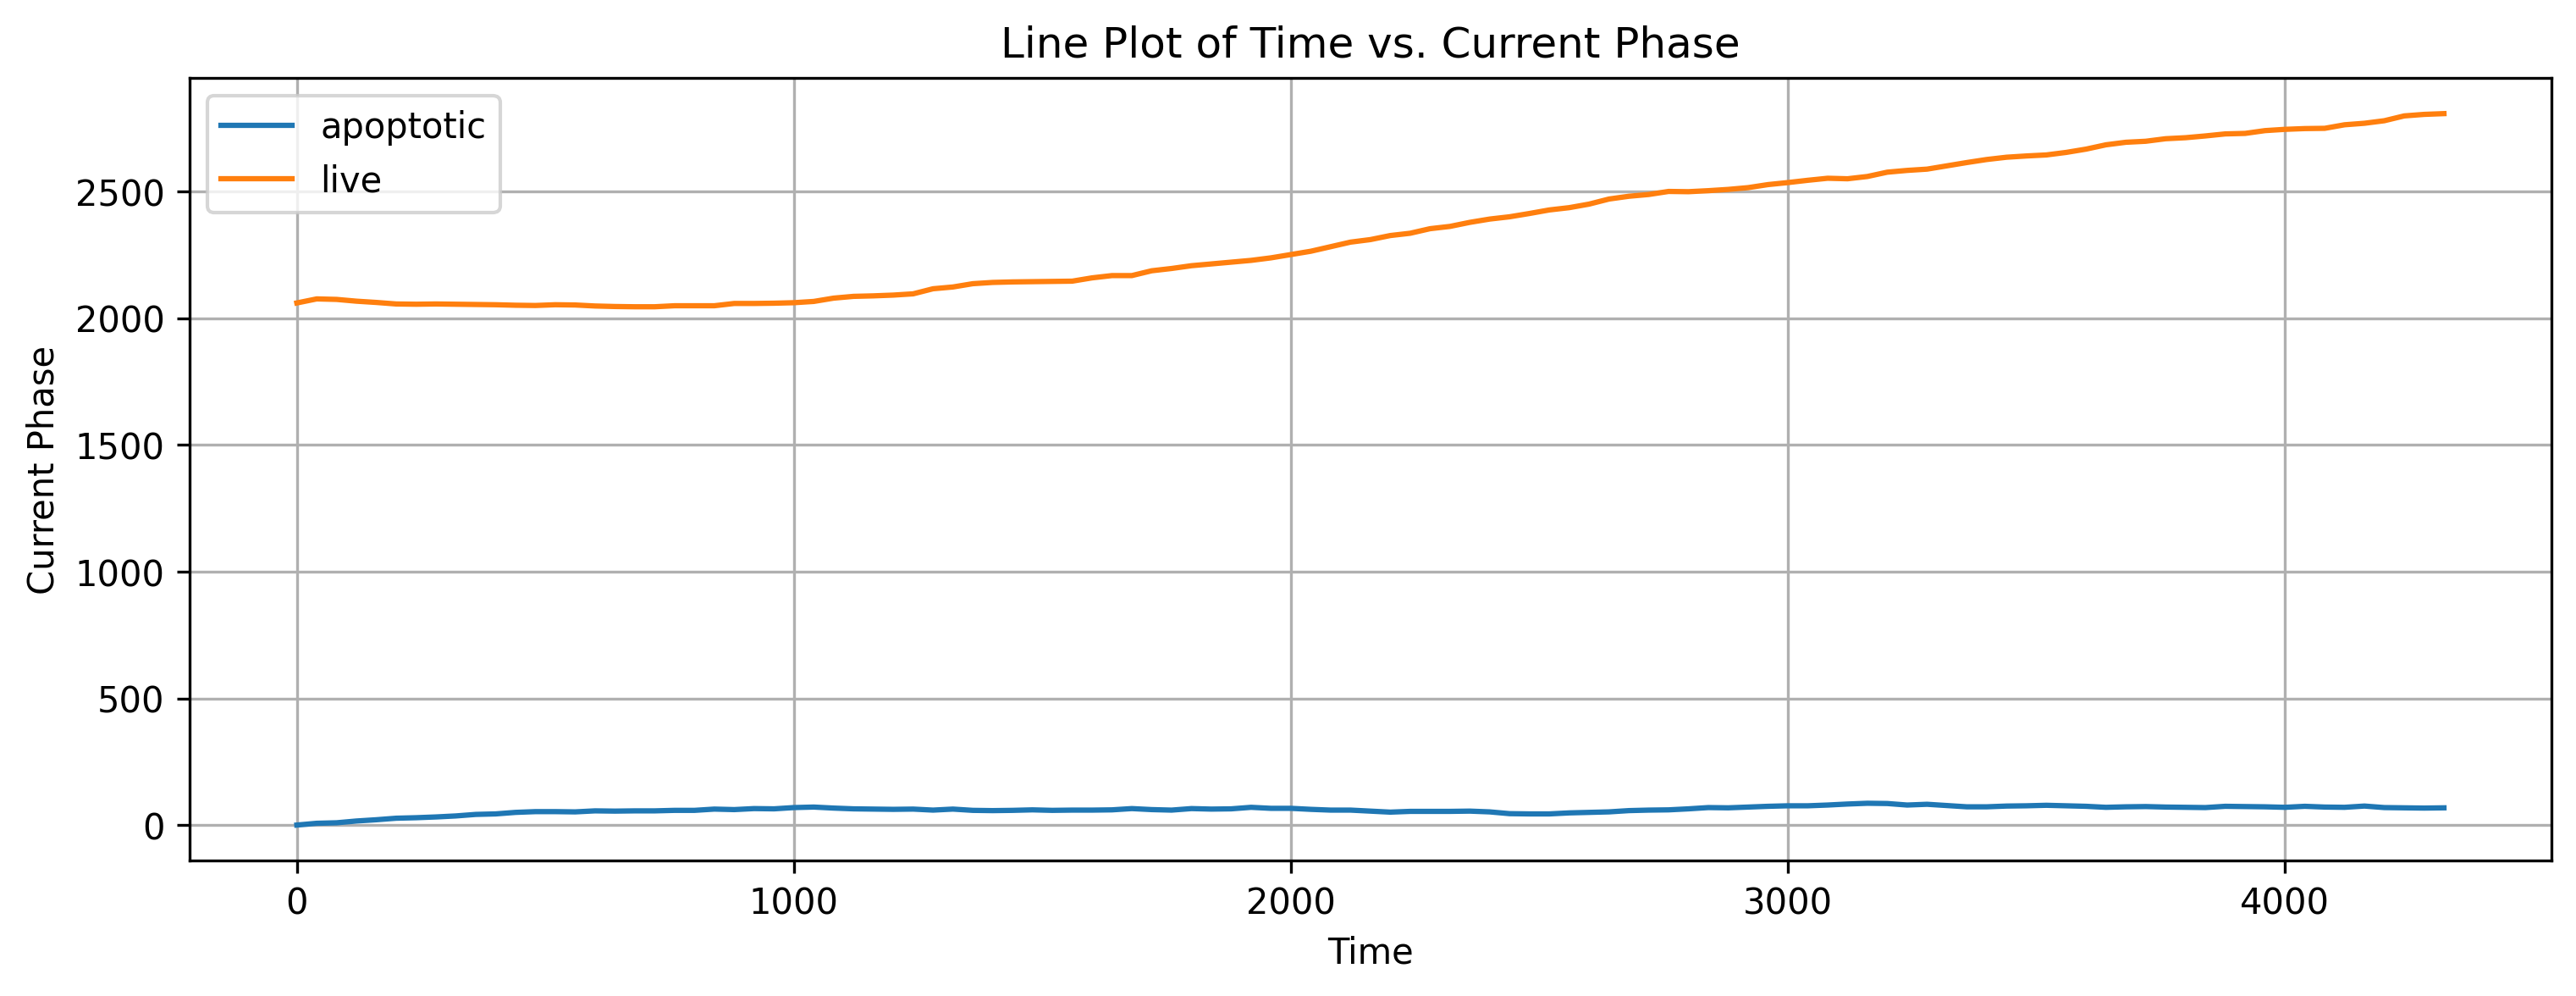

In [15]:
def plot_cells(df_time_course):

    # Subset the dataframe to only include 'time' and 'cell_type' columns
    df_subset = df_time_course[['time', 'current_phase']]
    
    # Group by 'time' and 'cell_type', count occurrences, and unstack to create columns for each cell type
    df_aggregated = df_subset.groupby(['time', 'current_phase']).size().unstack(fill_value=0)
    
    # Reset index to make 'time' a column again
    df_aggregated = df_aggregated.reset_index()
    
    # Melt the dataframe to long format for seaborn
    df_melted = pd.melt(df_aggregated, id_vars=['time'], var_name='current_phase', value_name='count')
    
    # Create the plot
    plt.figure(figsize=(12, 4), dpi=300)
    ax = sns.lineplot(data=df_melted, x='time', y='count', hue='current_phase')
    plt.legend(title='Current Phase')
    plt.xlabel('Time')
    plt.ylabel('Current Phase')
    plt.title('Live cell plot')
    # plt.set_ylabel("Number of cells")

    # Showing legend
    plt.legend()
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    plt.savefig(os.path.join(instance_folder, 'cellgrowth.png'), dpi=300)

    print("Alive/Apoptotic cells plot obtained")


# fig, axes = plt.subplots(4, 1, figsize=(12, 12), dpi=300, sharex=True, sharey=False) # original size is (12, 12)
plot_cells(df_time_course)


### plotting drug densities

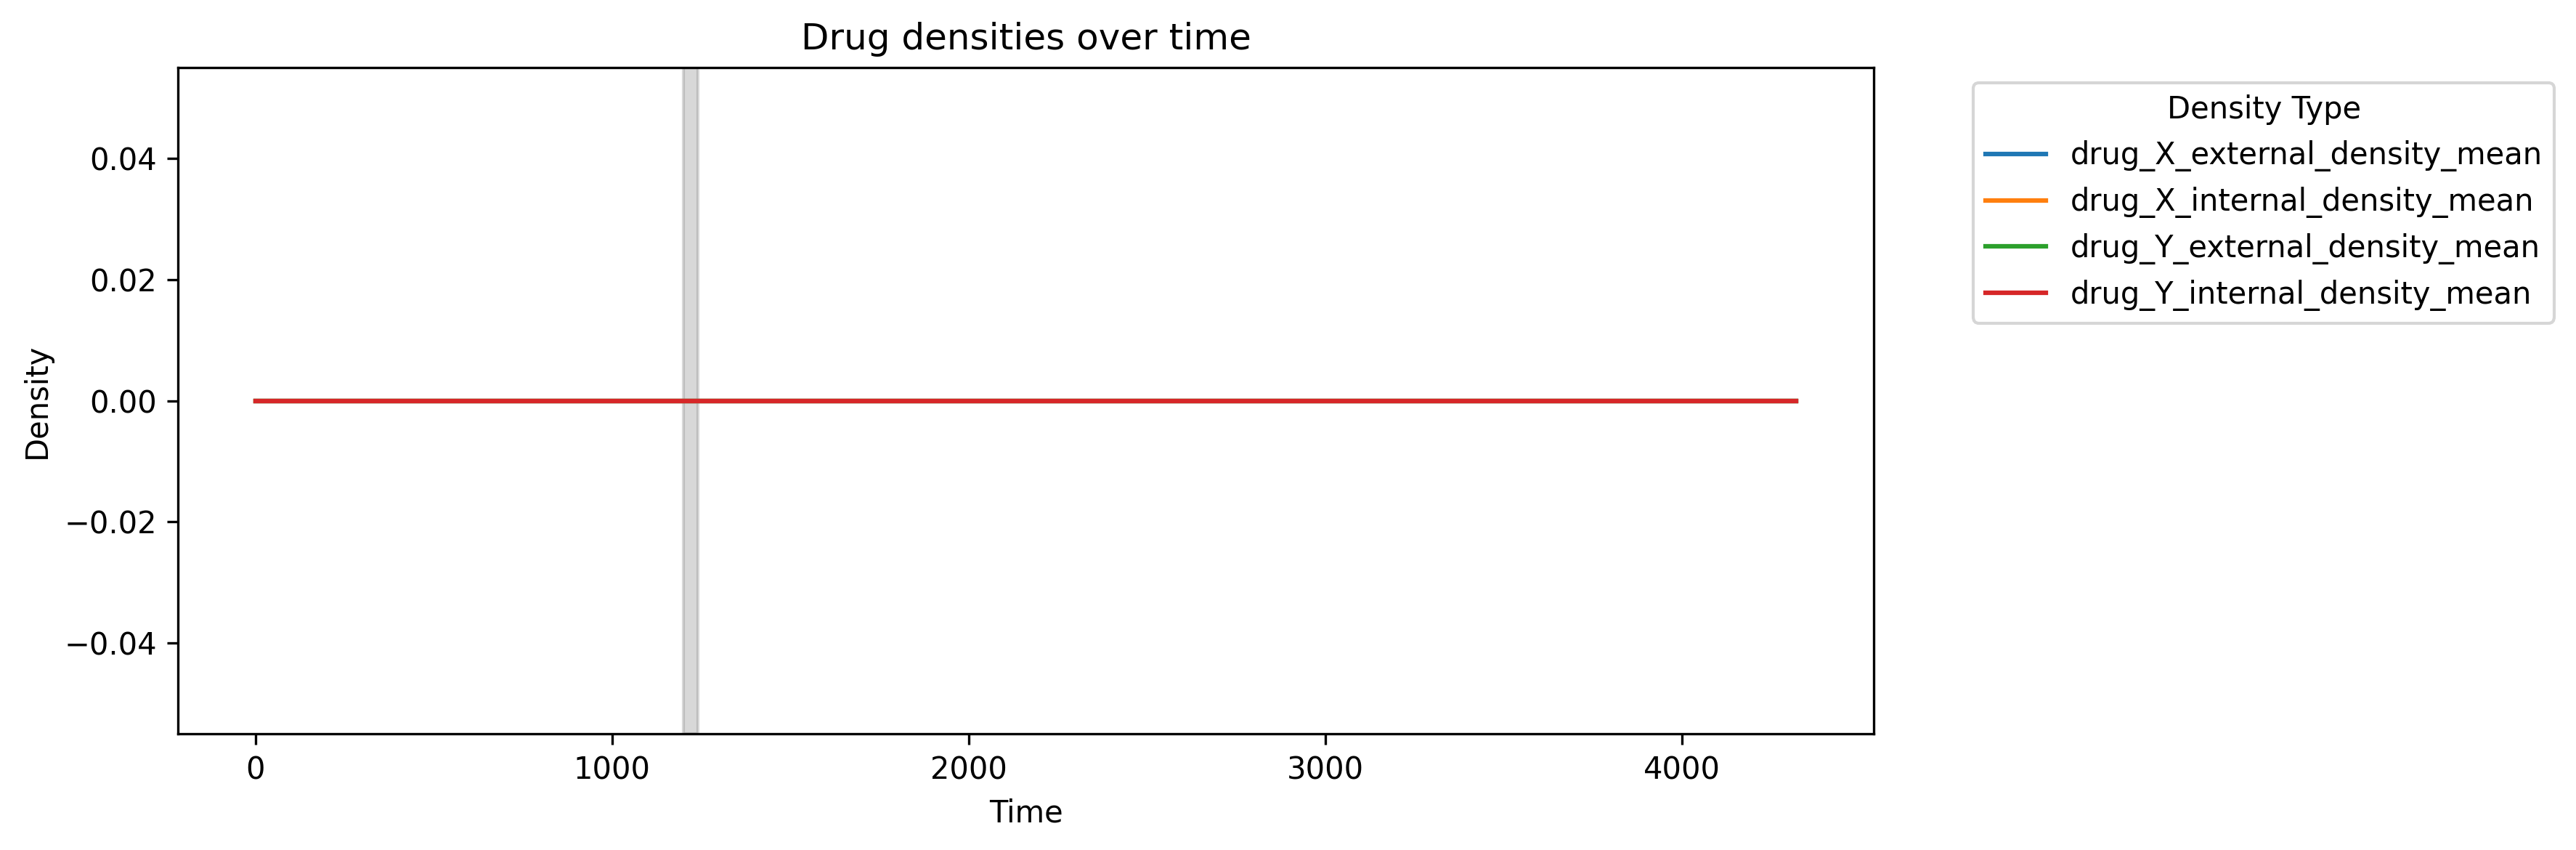

In [57]:
def process_and_plot_density(df, experiment_type):
    # Select columns containing 'internal_density' or 'external_density', and 'time'
    if experiment_type=="single":
        density_cols = df.filter(regex='internal_density|external_density').filter(regex='^(?!.*oxygen)').filter(regex='^(?!.*drug_Y)').columns
    else:
        density_cols = df.filter(regex='internal_density|external_density').filter(regex='^(?!.*oxygen)').columns
    selected_cols = list(density_cols) + ['time']
    df_subset = df[selected_cols]

    # Group by time and calculate mean and std for each density column
    df_aggregated = df_subset.groupby('time').agg(['mean', 'std'])

    # Flatten column names
    df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

    # Reset index to make 'time' a column again
    df_aggregated = df_aggregated.reset_index()

    # Melt the dataframe to long format for seaborn
    df_melted = pd.melt(df_aggregated, id_vars=['time'], 
                        value_vars=[col for col in df_aggregated.columns if col.endswith('_mean')],
                        var_name='density_type', value_name='density')

    # Create a corresponding dataframe for standard deviation
    df_melted_std = pd.melt(df_aggregated, id_vars=['time'], 
                            value_vars=[col for col in df_aggregated.columns if col.endswith('_std')],
                            var_name='density_type', value_name='std')
    df_melted_std['density_type'] = df_melted_std['density_type'].str.replace('_std', '_mean')

    # Merge mean and std dataframes
    df_melted = pd.merge(df_melted, df_melted_std, on=['time', 'density_type'])

    # Create the plot
    plt.figure(figsize=(12, 4), dpi=300)
    ax = sns.lineplot(data=df_melted, x='time', y='density', hue='density_type')

    # Add shaded region for standard deviation
    for name, group in df_melted.groupby('density_type'):
        ax.fill_between(group['time'], group['density'] - group['std'], 
                        group['density'] + group['std'], alpha=0.2)

    # Add shaded grey region from x=1200 to x=1240
    plt.axvspan(1200, 1240, color='grey', alpha=0.3)

    plt.title('Drug densities over time')
    plt.xlabel('Time')
    plt.ylabel('Density')

    # Move legend outside the plot
    plt.legend(title='Density Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('densities_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming your dataframe is named 'df', call the function like this:
# process_and_plot_density(df)
# fig, axes = plt.subplots(4, 1, figsize=(12, 12), dpi=300, sharex=True, sharey=False) # original size is (12, 12)
process_and_plot_density(df_time_course)

### plotting curve comparison 

(2060, 2875)

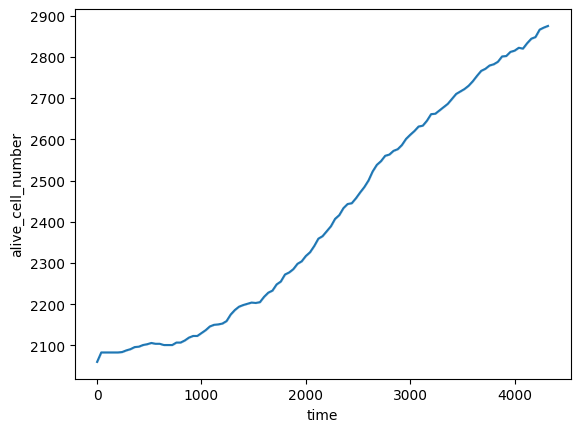

In [45]:
def get_min_max_wt_sim_curve(input_df):

    # df_merged_path = "/home/oth/BSC/my_PB_branch/drugsyn_pboss/PhysiBoSS/NEW_full_runs/2_naive_BM/MEK-AKT/output_1/full_data_merged.csv"
    # df_merged = pd.read_csv(input_df)
    # df_merged = input_df.sort_values(["time", "ID"], ascending=True)

    df = input_df[input_df['current_phase'] != 'alive']
    # Calculate total number of cells for each time point
    df['alive_cell_number'] = df.groupby('time')['ID'].transform('nunique')
    initial_cell_number = df.loc[0, 'alive_cell_number']

    sim_curve_max = df['alive_cell_number'].max()
    sim_curve_min = df['alive_cell_number'].min()
    
    return sim_curve_min, sim_curve_max

get_min_max_wt_sim_curve(df_time_course)


In [56]:
def normalize_sim_curve_control(input_df):
    """ normalize simulation curve coming from the df_time_course dataframe from MCDS """

    df = input_df[input_df['current_phase'] != 'alive']
    # Calculate total number of cells for each time point
    df['alive_cell_number'] = df.groupby('time')['ID'].transform('nunique')
    initial_cell_number = df.loc[0, 'alive_cell_number']

    # Now get the normalized column
    subset_df = df.loc[:, ['time', 'alive_cell_number']]
    subset_df['adjusted_alive_cell_number'] = subset_df['alive_cell_number'] - initial_cell_number

    max_value = subset_df['adjusted_alive_cell_number'].max()
    min_value = subset_df['adjusted_alive_cell_number'].min()
    subset_df['normalized_alive_cell_number'] = ((subset_df['adjusted_alive_cell_number'] - min_value) / (max_value - min_value)) * 100

    df_unique = subset_df.drop_duplicates()

    return df_unique.time, df_unique.normalized_alive_cell_number


normalize_sim_curve_control(df_time_course)



,time,alive_cell_number,adjusted_alive_cell_number,normalized_alive_cell_number
0,0.0,2060,0,0.000000
2060,40.0,2083,23,2.822086
4143,80.0,2083,23,2.822086
6226,120.0,2083,23,2.822086
8309,160.0,2083,23,2.822086
...,...,...,...,...
248407,4160.0,2844,784,96.196319
251251,4200.0,2848,788,96.687117
254099,4240.0,2866,806,98.895706
256965,4280.0,2871,811,99.509202


### plotting BM nodes

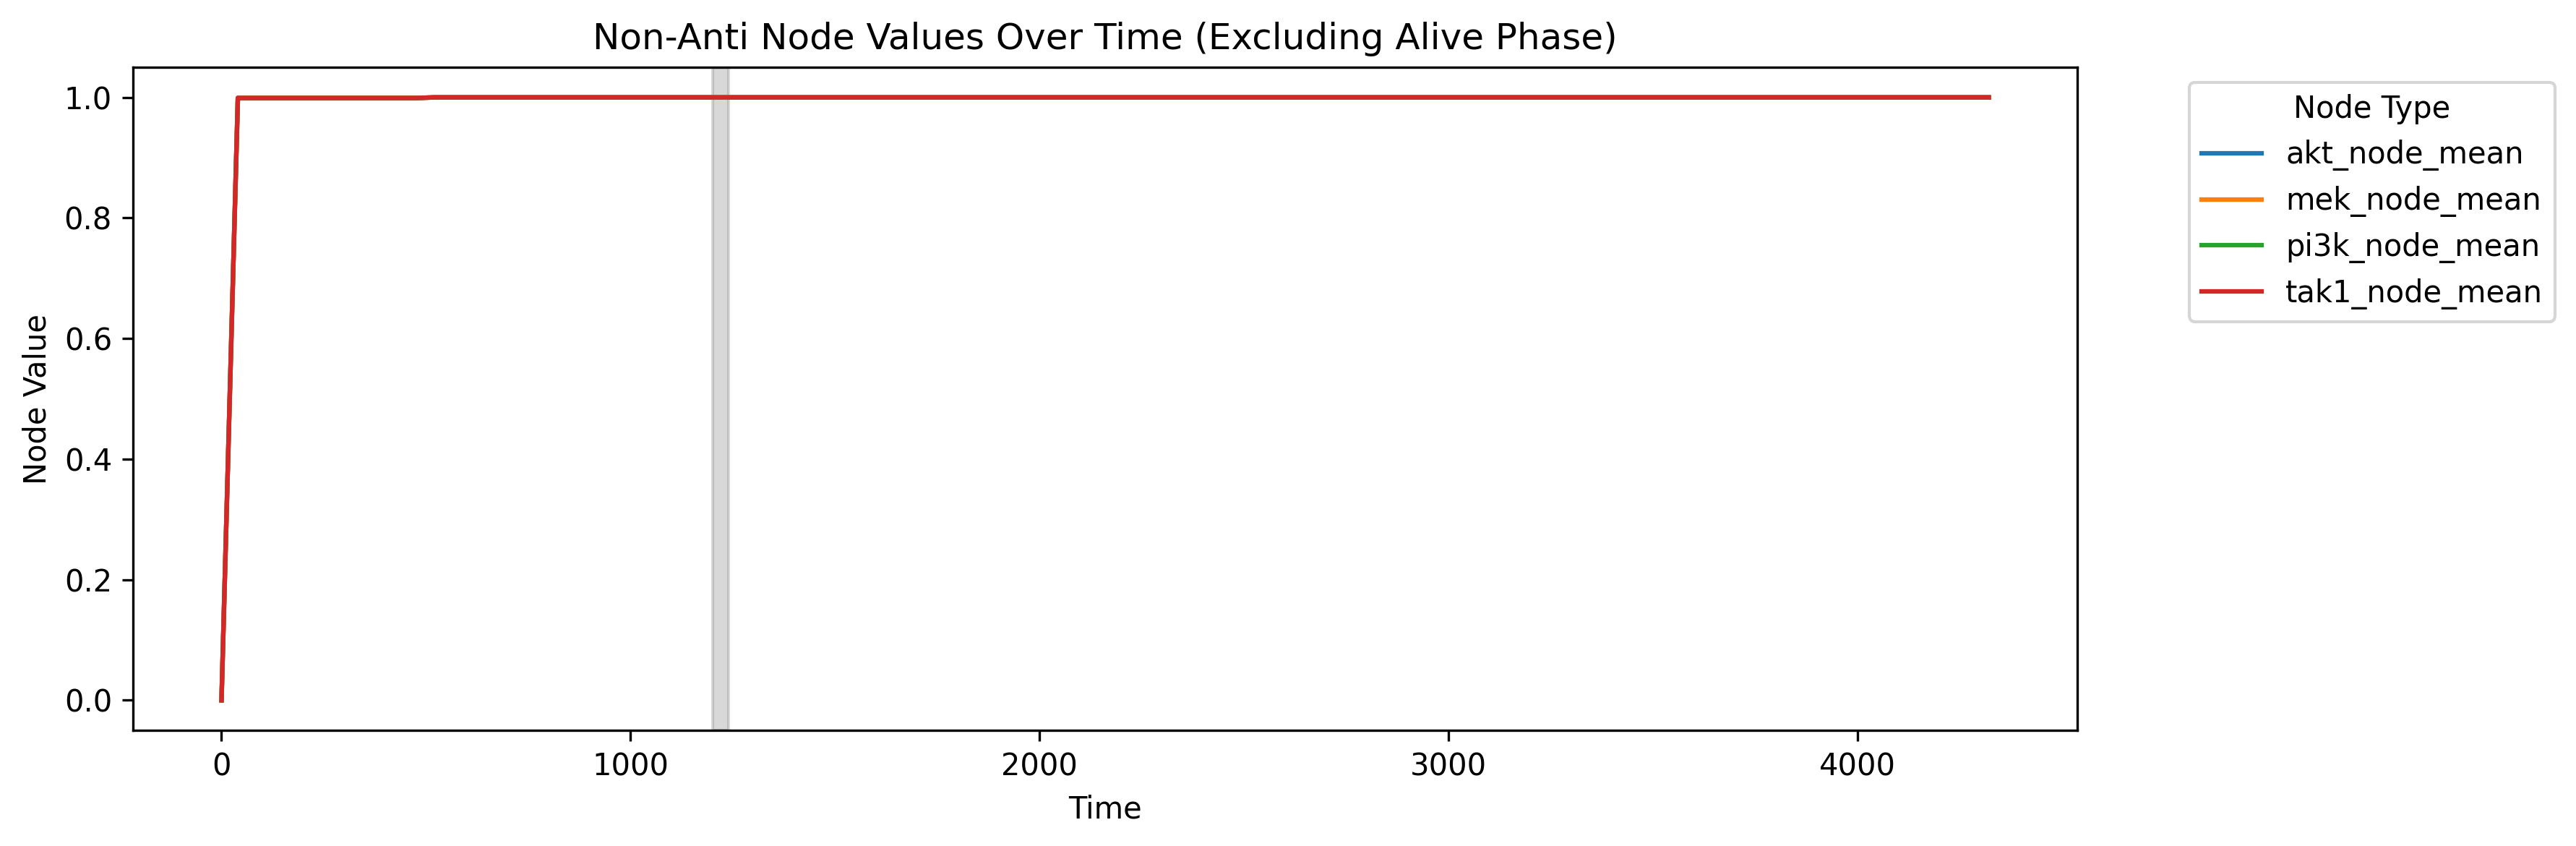

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def process_and_plot_nodes(df):
    # Filter out rows where 'current_phase' is 'alive'
    df = df[df['current_phase'] != 'alive']

    # Select columns containing 'node' but not 'anti', and 'time'
    node_cols = df.filter(regex='node').filter(regex='^(?!.*anti)').columns
    selected_cols = list(node_cols) + ['time']
    df_subset = df[selected_cols]

    # Group by time and calculate mean and std for each node column
    df_aggregated = df_subset.groupby('time').agg(['mean', 'std'])

    # Flatten column names
    df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

    # Reset index to make 'time' a column again
    df_aggregated = df_aggregated.reset_index()

    # Melt the dataframe to long format for seaborn
    df_melted = pd.melt(df_aggregated, id_vars=['time'], 
                        value_vars=[col for col in df_aggregated.columns if col.endswith('_mean')],
                        var_name='node_type', value_name='value')

    # Create a corresponding dataframe for standard deviation
    df_melted_std = pd.melt(df_aggregated, id_vars=['time'], 
                            value_vars=[col for col in df_aggregated.columns if col.endswith('_std')],
                            var_name='node_type', value_name='std')
    df_melted_std['node_type'] = df_melted_std['node_type'].str.replace('_std', '_mean')

    # Merge mean and std dataframes
    df_melted = pd.merge(df_melted, df_melted_std, on=['time', 'node_type'])

    # Create the plot
    plt.figure(figsize=(12, 4), dpi=300)
    ax = sns.lineplot(data=df_melted, x='time', y='value', hue='node_type')

    # Add shaded region for standard deviation
    # for name, group in df_melted.groupby('node_type'):
    #     ax.fill_between(group['time'], group['value'] - group['std'], 
    #                     group['value'] + group['std'], alpha=0.2)

    # Add shaded grey region from x=1200 to x=1240
    plt.axvspan(1200, 1240, color='grey', alpha=0.3)

    plt.title('Non-Anti Node Values Over Time (Excluding Alive Phase)')
    plt.xlabel('Time')
    plt.ylabel('Node Value')

    # Move legend outside the plot
    plt.legend(title='Node Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('nodeplot_timecourse.png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming your dataframe is named 'df', call the function like this:
process_and_plot_nodes(df_time_course)

In [63]:
def plot_molecular_model(df_cell_variables, list_of_variables, threshold=0.5):

    print(df_cell_variables)

    for label in list_of_variables:

        y = df_cell_variables[label]
        time = df_cell_variables["time"]
        
        plt.plot(time, y, label=label + " state")

    plt.legend()
    plt.set_ylabel("Mean Boolean node state")
    plt.yaxis.grid(True)
    plt.xaxis.grid(True)


list_of_variables = ['mek_node', 'pi3k_node', 'akt_node', 'tak1_node']
plot_molecular_model(df_cell_variables, list_of_variables)


     index           ID  K_half_apoptosis  K_half_growth  akt_node  \
0        0  1029.500000               0.0            0.0       0.0   
1        1  1041.053468               0.0            0.0       1.0   
2        2  1040.280617               0.0            0.0       1.0   
3        3  1040.505080               0.0            0.0       1.0   
4        4  1040.813288               0.0            0.0       1.0   
..     ...          ...               ...            ...       ...   
104    104  1703.400506               0.0            0.0       1.0   
105    105  1712.557755               0.0            0.0       1.0   
106    106  1725.613653               0.0            0.0       1.0   
107    107  1731.409772               0.0            0.0       1.0   
108    108  1735.918774               0.0            0.0       1.0   

     anti_akt_node  anti_mek_node  anti_pi3k_node  anti_tak1_node  \
0              0.0            0.0             0.0             0.0   
1              0.0   

KeyError: 'time'